In [1]:
import numpy as np
import tensorflow as tf

2023-03-02 20:35:29.152518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-02 20:35:29.317426: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-02 20:35:40.178273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/gmp/6.2.1/b1/lib:/software/glpk/4.65/lib:/software/zmq/4.2.3/b1/lib:/software/git/2.30.1/lib64:/software/gcc/7.3.0/lib64:/software/gcc/7.3.0/lib:/software/openmpi/4.0.4/b1/lib:/software/cuda/11.4/usr/lo

In [3]:
pos_ohe_data = np.load("positive.npy",  allow_pickle=True)
neg_ohe_data = np.load("negative.npy",  allow_pickle=True)

def ohe_to_seq(ohe_pep):
    alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
    seq = ''
    # expect a 2D numpy array (pep_length x 20), give the string it represents
    for letter in ohe_pep[:int(np.sum(ohe_pep))]:
        idx = np.argmax(letter)
        if letter[idx] == 0:
            break
        seq += alphabet[idx]
    return(seq)

for vec in (pos_ohe_data):
    print(ohe_to_seq(vec))

IVADI
LRIQV
WIFIR
ITLIG
LVMGP
LFAEI
IFTAV
VQFIR
YTLVA
LHMGP
VMAEI
ILTEV
WMKIY
IHLYA
ALMIP
LHAII
ITTEV
WSKIY
TLLYA
ILMIP
VVAII
LVTEV
WMNIG
LNLYM
WMMMP
VTALI
IYTPV
WTQIL
VLLYP
VLMQP
LYANI
YITTV
WTQIT
IFLYS
VMMQP
IRAQI
IRTYV
WVRID
VMLYS
TEMVP
MYARI
MNVIV
WMRII
IVLYT
ILFIP
SYASI
WSVLV
WITIG
PMMIA
IVFVP
LVATI
MHVQV
WVTIN
VVMYS
VIFVP
LYATI
LRVRV
WTVIT
VTMYT
IIFYP
MYATI
LHVSV
WVYIG
VVMYT
MYATI
LRVSV
WMYIQ
IITIG
YAATI
WMYQV
WVYIR
IKTYP
LNAVI
LRAKL
WMQLS
IMTYP
LRAVI
IVAML
WVRLE
ITTYP
ISIEI
VIAQL
WMRLI
YVTYT
LNIVI
LRMQL
ITRLV
LYLQI
IQMVL
WMRLY
LNMTI
IVTLL
WTSLA
IFTAI
VNTTL
WTSLQ
YVTAI
IAVEL
WTSLY
IMTDI
IRVEL
WMTLN
IYTDI
VAVEL
WTVLY
VYTEI
IQVML
WTYLF
IMTII
IQVML
WTYLI
VTTII
INVQL
WMYLT
VTTLI
VTVQL
WMYLY
VYTQI
MNVTL
WMRMN
ISTYI
RAIVM
WTVTS
ITTYI
LYATF
WIYTR
INVEI
LNMTF
WVYTY
IHVMI
MSMVF
WTQYV
INVQI
YNMVF
WMRYQ
IWVSI
LYTSF
WTSYT
LRVSI
LNVIF
LTVTI
LNVLF
IIVVI
ITLVY
LYAQV
LRLVY
INIEV
QMYLY
ISIEV
LYYQY


In [5]:
RNs_found = np.load('../saved_models/shp2-rnn/spy_RNs_sampling.npy')

In [7]:
json_file = open('../saved_models/shp2-rnn/spy_model.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = tf.keras.models.model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights('../saved_models/shp2-rnn/spy_model_weights.h5') 
print("Loaded model from disk")

Loaded model from disk


In [8]:
np.unique(RNs_found, axis=0).shape

(162, 190)

In [9]:
def counts_aa(vec):
    counts =  tf.histogram_fixed_width(vec, [0, 20], nbins=21)[1:]
    return counts /tf.reduce_sum(counts)

y_hat_RN = loaded_model.predict([RNs_found, np.array([counts_aa(xi) for xi in RNs_found])])

2023-03-02 20:41:04.880086: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204


6/6 [==============================] - 4s 5ms/step


2023-03-02 20:41:05.813108: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


(array([ 8.,  8.,  3.,  4.,  7.,  7., 15., 14., 19., 77.]),
 array([0.07072526, 0.16188726, 0.25304925, 0.34421128, 0.43537328,
        0.5265353 , 0.6176973 , 0.70885926, 0.8000213 , 0.89118326,
        0.9823453 ], dtype=float32),
 <BarContainer object of 10 artists>)

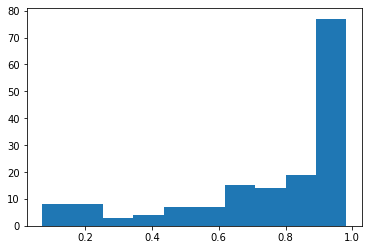

In [10]:
import matplotlib.pyplot as plt
plt.hist(y_hat_RN)

In [11]:
def decoder(seq_vector):
  alphabet = ['A','R','N','D','C','Q','E','G','H','I', 'L','K','M','F','P','S','T','W','Y','V']
  seq = []
  for i, index in enumerate(seq_vector.astype('int')):
    if index == 0:
      break
    seq.append(alphabet[index-1])
  seq = ''.join(seq)
  return seq

In [12]:
indices_sorted = np.argsort(y_hat_RN,axis=0)
# 5 most probable RN
most_likely_RN =  RNs_found[indices_sorted][:5]
# 5 least probable RN
least_likely_RN =  RNs_found[indices_sorted][-5:]

In [13]:
loaded_model.predict([most_likely_RN.squeeze(), np.array([counts_aa(xi) for xi in most_likely_RN.squeeze()])])

1/1 [==============================] - 0s 27ms/step


array([[0.0707215 ],
       [0.08515194],
       [0.09033306],
       [0.09328519],
       [0.09549117]], dtype=float32)

In [14]:
for vec in most_likely_RN:
    print(decoder(vec[0,:]))

YYASE
QVRAK
VANAT
NVAAT
TFGRM


In [15]:
for vec in least_likely_RN:
    print(decoder(vec[0,:]))

WVLYA
AVITW
TWIYT
WITAV
IFLYW


## Test against PN classifier trained on SHP2

In [16]:
json_file = open('../saved_models/shp2-rnn/PN_model.json', 'r')
PN_loaded_model_json = json_file.read()
json_file.close()
PN_loaded_model = tf.keras.models.model_from_json(PN_loaded_model_json)
# load weights into new model
PN_loaded_model.load_weights('../saved_models/shp2-rnn/PN_model_weights.h5') 
print("Loaded model from disk")

Loaded model from disk


In [17]:
PN_loaded_model.predict([most_likely_RN.squeeze(), np.array([counts_aa(xi) for xi in most_likely_RN.squeeze()])])

1/1 [==============================] - 3s 3s/step


array([[-2.8908055],
       [-4.457416 ],
       [-4.6339006],
       [-4.9624224],
       [-3.6902256]], dtype=float32)

In [19]:
PN_loaded_model.predict([least_likely_RN.squeeze(), np.array([counts_aa(xi) for xi in least_likely_RN.squeeze()])])

1/1 [==============================] - 0s 25ms/step


array([[2.7693696],
       [2.7280474],
       [2.8132837],
       [3.050894 ],
       [1.8668313]], dtype=float32)